# How to use SCREENER and RDP Search for finding Bons ESG Data - JupyterLab

This Notebook demonstrates how to use Eikon SCREENER application to find the companies with the [Eikon Data API](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api), then find the Bonds that issued by that company with [Refinitiv Data Platform Library for Python](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries) Search function, and get the Environmental, Social, and Governance (ESG) data of the Bonds via the Eikon Data API.

## Importing Libraries

The first step is importing all required libraries including the RDP Library for Python, Eikon Data API, Pandas, etc.

In [1]:
import refinitiv.dataplatform as rdp # RDP Library for Python
import refinitiv.dataplatform.eikon as ek # Eikon Data API
import datetime
import pandas as pd
from dotenv import load_dotenv
import os

%load_ext dotenv
%dotenv

### Connecting to Eikon Data API and RDP Session

This code sets 
- the `app_id` to connect to the **Eikon Data API** via the **Refinitiv Workspace/Eikon Desktop Application** which needs to be running locally. 
- the RDP `app_key`, `usrname`, and `password` to connect to the RDP Open Platform Session.

You need the following Environment Variables in your OS setting:

```
#RDP
RDP_USERNAME=YOUR_RDP_USERNAME
RDP_PASSWORD=YOUR_RDP_PASSWORD
RDP_APP_KEY=YOUR_RDP_APP_KEY_HERE
# Eikon Data API
EIKON_APP_KEY=YOUR_EIKON_APP_ID_HERE

```

Alternatively, you can create a text file with **filename** `.env` having the above contents:
    
This file (or OS Environment Variables) should be readily available (e.g. in the current working directory) for the next steps.

Initialize RDP Library for Python session.

In [2]:
rdp.open_platform_session(
    os.getenv('RDP_APP_KEY'),
    rdp.GrantPassword(
        username = os.getenv('RDP_USERNAME'),
        password = os.getenv('RDP_PASSWORD')
    )
)

Initialize Eikon Data API session.

Please note that the Refinitiv Workspace/Eikon application integrates a Data API proxy that acts as an interface between the Eikon Data API Python library and the Eikon Data Platform. For this reason, the Refinitiv Workspace/Eikon application must be running when you use the Eikon Data API Python library.

In [3]:
ek.set_app_key(os.getenv('EIKON_APP_KEY'))

## SCREENER to Python

Article: [Find Your Right Companies with SCREENER | Eikon Data APIs(Python)](https://developers.refinitiv.com/en/article-catalog/article/find-your-right-companies-with-screener-eikon-data-apis-python).

### Screener Formula

**Excel Formula**: Contain both formula and fields

```
=@TR("SCREEN(U(IN(Equity(active,public,primary))/*UNV:Public*/), IN(TR.ExchangeCountryCode,""CN""), TR.TRESGCScore(Period=FY0)>=50, CURN=USD)","TR.CommonName;TR.ExchangeCountry;TR.TRESGCScore(Period=FY0)","curn=USD RH=In CH=Fd")
```

Which can be separated to Formula and Fields:

*Formula*
```
"SCREEN(U(IN(Equity(active,public,primary))/*UNV:Public*/), IN(TR.ExchangeCountryCode,""CN""), TR.TRESGCScore(Period=FY0)>=50, CURN=USD)"
```
*Fields*
```
"TR.CommonName;TR.HeadquartersCountry;TR.TRESGCScore(Period=FY0)"
```

Change to **Python Syntax** string: 
```
syntax = 'SCREEN(U(IN(Equity(active,public,primary))), IN(TR.ExchangeCountryCode,"CN"), TR.TRESGCScore>=50, CURN=USD)'
```
And **Python field**: 
```
fields = ['TR.CommonName', 'TR.HeadquartersCountry','TR.TRESGCScore']
```

We will add the ESG Score, ESG Controversies Score and ESG Combined Score Grade fields to the requested fields too.

```
fields = ['TR.CommonName', 'TR.HeadquartersCountry','TR.TRESGCScore', 'TR.TRESGScore', 'TR.TRESGCControversiesScore', 'TR.TRESGCScoreGrade']
```

In [4]:
# Python Syntax string
syntax = 'SCREEN(U(IN(Equity(active,public,primary))), IN(TR.ExchangeCountryCode,"CN"), TR.TRESGCScore>=50, CURN=USD)'

# With Combined Score Grade A or Combined Score Grade B
"""
syntax ='SCREEN(U(IN(Equity(active,public,primary))), IN(TR.HQCountryCode,"CN"), '\
    'TR.TRESGCScore>=50,'\
    'Contains(TR.TRESGCScoreGrade,"A") OR Contains(TR.TRESGCScoreGrade,"B"),'\
    'CURN=USD)'
"""

# Fields
fields = ['TR.CommonName', 'TR.HeadquartersCountry','TR.TRESGCScore', 'TR.TRESGScore', 'TR.TRESGCControversiesScore', 'TR.TRESGCScoreGrade']

Requesting data with Eikon Data API ```get_data()``` function.

In [5]:
df_list_companies, err = ek.get_data(syntax, fields)
df_list_companies

,Instrument,Company Common Name,Country of Headquarters,ESG Combined Score,ESG Score,ESG Controversies Score,ESG Combined Score Grade
0,002415.SZ,Hangzhou Hikvision Digital Technology Co Ltd,China,62.872819,62.872819,96.875,B
1,002475.SZ,Luxshare Precision Industry Co Ltd,China,68.844468,68.844468,100.0,B+
2,601377.SS,China Industrial Securities Co Ltd,China,58.822716,58.822716,100.0,B
3,601933.SS,Yonghui Superstores Co Ltd,China,52.740132,52.740132,100.0,B-
4,002555.SZ,Wuhu Sanqi Interactive Entertainment Network T...,China,62.471869,62.471869,100.0,B
...,...,...,...,...,...,...,...
99,601618.SS,Metallurgical Corporation of China Ltd,China,58.696757,58.696757,100.0,B
100,300012.SZ,Centre Testing International Group Co Ltd,China,50.632709,50.632709,100.0,B-
101,600999.SS,China Merchants Securities Co Ltd,China,51.434806,51.434806,100.0,B-
102,002340.SZ,GEM Co Ltd,China,53.274907,53.274907,100.0,B-


## Bond Searching with RDP

Articles: 
- [Building Search into your Application Workflow](https://developers.refinitiv.com/en/article-catalog/article/building-search-into-your-application-workflow).
- [Debt Structure Analysis on an Organizational Level](https://developers.refinitiv.com/en/article-catalog/article/debt-structure-analysis-on-an-organizational-level).

### Company Selection
The following procedures can be used to determine the company of interest based on its Organization ID, or Company Perm ID with the providing the company Name.

In [6]:
df_list_companies['Company Common Name'].iloc[0]

'Hangzhou Hikvision Digital Technology Co Ltd'

In [7]:
# Determine the organization ID using Search.
df_company_permID = rdp.search(
    view = rdp.SearchViews.GovCorpInstruments,
    top = 5,
    query= df_list_companies['Company Common Name'].iloc[0],
    filter = "ParentOAPermID ne null",
    select = 'ParentOAPermID'
)
df_company_permID 

,ParentOAPermID
0,5000036491
1,5000036491


Alternatively, you can get the Company Perm ID value with the input Instrument name via the Eikon Data API ```get_data``` function as wel.

In [8]:
df_list_companies['Instrument'].iloc[0]

'002415.SZ'

In [9]:
df, err = ek.get_data(df_list_companies['Instrument'].iloc[0], 'TR.UltimateParentId')
df

,Instrument,Ultimate Parent Id
0,002415.SZ,5000036491


Once determined, assign the value below that will be named 'org_id' in our code going forward.

**Note**: We could possibly use the company name as the search criteria in our main searching of bonds, as opposed to finding the organization id, but we want to ensure we're referring to the actual company as opposed to the possibility of returning results that closely match based on the company expression provided.

In [10]:
org_id = df_company_permID['ParentOAPermID'].iloc[0]
org_id

'5000036491'

The following request utilizes the RDP Search call to select the list of bonds associated with the defined company. 

> The *rdp.search()* API call is a powerful utility offering detailed search analysis that developers can customize for their requirements.  The output, i.e. columns or fields returned, is based on the *select* parameter - see below.  The specific selection of these properties has been determined by utilizing Search metadata analysis and debugging features.  These features provide the ability to interrogate the values returned, allowing the user to determine the desired properties.  For additional details around Search and how to get the most out of this service, refer to the *[Building Search into your Application Workflow](https://developers.refinitiv.com/en/article-catalog/article/building-search-into-your-application-workflow)* article.

First, define the output fields/properties of interest. In the article mentioned above, you will find the steps to finding the entire universe of properties/fields (what we know as Data Items in Eikon) for the universe you're looking at. In this case, we are looking at GovCorpInstruments and have chosen a handful of properties to include.

In [11]:
# Define the collection of properties/fields within our result set
properties = ['ISIN', 'RIC','DBSTicker', 'IssueDate', 'Currency', 'RCSCurrencyLeaf', 'FaceIssuedTotal', 
              'EOMAmountOutstanding', 'NextCallDate', 'CouponRate', 'IsPerpetualSecurity', 'MaturityDate', 
              'CdsSeniorityEquivalentDescription']

# Populate empty columns
# In some cases, depending on the specified company, the result set may contain unavailable columns of data 
# within the result set.  The following logic will ensure our results will contain the necessary columns of data.
def populate_empty_columns(df):
    for prop in properties:
        if (prop not in df):
            df[prop] = pd.NA  

We can search Government & Corporate Bonds with the ```GovCorpInstruments``` Search view. To see the list of supported Views, please use the Python built-in help function.

In [12]:
help(rdp.SearchViews)

Help on class SearchViews in module refinitiv.dataplatform.content.search.SearchViews:

class SearchViews(enum.Enum)
 |  SearchViews(value, names=None, *, module=None, qualname=None, type=None, start=1)
 |  
 |  define all possible views
 |  
 |  Method resolution order:
 |      SearchViews
 |      enum.Enum
 |      builtins.object
 |  
 |  Data and other attributes defined here:
 |  
 |  BondFutOptQuotes = <SearchViews.BondFutOptQuotes: 'BondFutOptQuotes'>
 |  
 |  CdsInstruments = <SearchViews.CdsInstruments: 'CdsInstruments'>
 |  
 |  CdsQuotes = <SearchViews.CdsQuotes: 'CdsQuotes'>
 |  
 |  CmoInstruments = <SearchViews.CmoInstruments: 'CmoInstruments'>
 |  
 |  CmoQuotes = <SearchViews.CmoQuotes: 'CmoQuotes'>
 |  
 |  CommodityQuotes = <SearchViews.CommodityQuotes: 'CommodityQuotes'>
 |  
 |  DealsMergersAndAcquisitions = <SearchViews.DealsMergersAndAcquisitions...
 |  
 |  DerivativeInstruments = <SearchViews.DerivativeInstruments: 'Derivativ...
 |  
 |  DerivativeQuotes = <Searc

Next, you can search all supported Filters of each View with the ```rdp.get_search_metadata()``` function.

In [13]:
df = rdp.get_search_metadata(view = rdp.SearchViews.GovCorpInstruments)
df.head()

,,Type,Searchable,Sortable,Navigable,Groupable,Exact,Symbol
AccrualDate,AccrualDate,Date,True,True,True,False,False,False
AccruedInterest,AccruedInterest,Double,True,True,True,False,False,False
ActiveEstimatesExist,ActiveEstimatesExist,Boolean,True,False,False,False,False,False
AdtLocalCurrencyValue,AdtLocalCurrencyValue,String,True,False,False,False,False,False
AdtLocalCurrencyValueName,AdtLocalCurrencyValueName,String,True,False,False,False,False,False


We use the ```rdp.search()``` API to search the list of Active Bonds with CouponRate > = 6

In [14]:
df_bonds = rdp.search(
    # The 'view' represents a specific domain of content we wish to search across.  
    view = rdp.SearchViews.GovCorpInstruments,
    
    # The 'filter' parameter is a powerful, criteria-based, syntax that allows us to filter for specific 
    # results.
    #
    # Note: The expression below utilizes a convenient, modern Python syntax called 'String interpolation'.
    #       This feature utilizes f-strings to embed arguments within the string result. 
    #       Refer to the site: https://www.programiz.com/python-programming/string-interpolation for more 
    #       details.
    #
    # Disclaimer: The following expression includes bonds that are in 'default'.  If you choose to ignore 
    #             these from your result set, simply modify the expression below as follows:
    #
    #             "..not(AssetStatus in ('MAT' 'DEF'))"
    #
    filter = f"ParentOAPermID eq '{org_id}' and IsActive eq true and not(AssetStatus in ('MAT')) and RIC ne null and ISIN ne null and CouponRate ge 6",

    # Define the upper limit of rows within our result set.  This is a system imposed maximum value.
    top = 10000,

    # The 'select' parameter determines the fields of interest in our output.  The logic below takes our 
    # list of properties defined and creates the appropriate comma-separated list of properties required 
    # by the service.
    select = ','.join(properties),
    
    # The navigator will list all the unique currencies associated with the result set.  Used below for 
    # conversion.
    navigators = "Currency"
)

# When using search, the order of the columns in our result set are not ordered based on the properties 
# defined within the above 'select' statement.  As a result, I will re-order them for a more intuitive 
# display.  
#
# Before I reorder them, I will need to ensure our columns exist.
populate_empty_columns(df_bonds)

# Now we can re-order the columns
df_bonds = df_bonds[properties]
df_bonds

,ISIN,RIC,DBSTicker,IssueDate,Currency,RCSCurrencyLeaf,FaceIssuedTotal,EOMAmountOutstanding,NextCallDate,CouponRate,IsPerpetualSecurity,MaturityDate,CdsSeniorityEquivalentDescription
0,XS1142380820,CN114238082=,ICBAF,2014-12-10T00:00:00.000Z,EUR,Euro,600000000,600000000.0,2021-12-10T00:00:00.000Z,6.0,True,<NA>,Preferred Securities
1,CND100018ZW0,CN101754091=,SCJLH,2017-11-15T00:00:00.000Z,CNY,Chinese Yuan,300000000,300000000.0,2022-11-16T00:00:00.000Z,6.5,True,<NA>,Senior Unsecured
2,CND100015DG6,CN101760077=,CHSTAR,2017-12-26T00:00:00.000Z,CNY,Chinese Yuan,2500000000,2500000000.0,2022-12-28T00:00:00.000Z,7.0,True,<NA>,Senior Unsecured
3,CND100015Y21,CN101800168=,SASARS,2018-03-07T00:00:00.000Z,CNY,Chinese Yuan,1000000000,1000000000.0,2022-03-09T00:00:00.000Z,8.64,True,<NA>,Senior Unsecured
4,CND100017RQ1,CN101800677=,SCJLH,2018-06-07T00:00:00.000Z,CNY,Chinese Yuan,300000000,300000000.0,2023-06-08T00:00:00.000Z,7.5,True,<NA>,Senior Unsecured
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,CND10002H3L8,CN041900355=,PEKUUF,2019-09-10T00:00:00.000Z,CNY,Chinese Yuan,3000000000,<NA>,<NA>,6.3,False,2020-09-12T00:00:00.000Z,Senior Unsecured
278,CND100018F47,CN101564007=,SYMTC,2015-04-07T00:00:00.000Z,CNY,Chinese Yuan,500000000,<NA>,<NA>,6.5,False,2020-04-09T00:00:00.000Z,Senior Unsecured
279,CND100012533,CN101560055=,SEGOVC,2015-09-23T00:00:00.000Z,CNY,Chinese Yuan,1000000000,1000000000.0,<NA>,6.7,True,<NA>,Senior Unsecured
280,XS1332351169,CN133235116=,TSIHUG,2015-12-10T00:00:00.000Z,USD,US Dollar,450000000,450000000.0,<NA>,6.0,False,2020-12-10T00:00:00.000Z,Senior Unsecured


## Requesting ESG data of the Bonds list

Firstly, convert the DataFrame RIC column to the Python list.

In [15]:
instruments = df_bonds['RIC'].tolist()

Then requesting ESG data with the ```ek.get_data()``` function.

In [16]:
# fields = ['TR.CommonName', 'TR.HeadquartersCountry','TR.TRESGCScore', 'TR.TRESGScore', 'TR.TRESGCControversiesScore', 'TR.TRESGCScoreGrade']
df_bonds_esg, err = ek.get_data(instruments, fields)
df_bonds_esg

,Instrument,Company Common Name,Country of Headquarters,ESG Combined Score,ESG Score,ESG Controversies Score,ESG Combined Score Grade
0,CN114238082=,Industrial and Commercial Bank of China Ltd,China,65.470564,65.470564,85.714286,B
1,CN101754091=,Sichuan Jiulong Hydropower Development Co Ltd,China,<NA>,<NA>,<NA>,
2,CN101760077=,China Construction Seventh Engineering Divisio...,China,<NA>,<NA>,<NA>,
3,CN101800168=,China National Bluestar Group Co Ltd,China,<NA>,<NA>,<NA>,
4,CN101800677=,Sichuan Jiulong Hydropower Development Co Ltd,China,<NA>,<NA>,<NA>,
...,...,...,...,...,...,...,...
277,CN041900355=,Peking University Founder Group Corp,China,<NA>,<NA>,<NA>,
278,CN101564007=,Shenyang Machine Tool Co Ltd,China,<NA>,<NA>,<NA>,
279,CN101560055=,Shenyang Machine Tool Group Co Ltd,China,<NA>,<NA>,<NA>,
280,CN133235116=,Unigroup International Holdings Ltd,China,<NA>,<NA>,<NA>,


Please note that some bonds may not have ESG data, so we will drop the bonds that do not have ESG data from the DataFrame.

In [17]:
df_bonds_esg.dropna(subset = ['ESG Score'], inplace = True)
df_bonds_esg

,Instrument,Company Common Name,Country of Headquarters,ESG Combined Score,ESG Score,ESG Controversies Score,ESG Combined Score Grade
0,CN114238082=,Industrial and Commercial Bank of China Ltd,China,65.470564,65.470564,85.714286,B
15,CN114238171=,Industrial and Commercial Bank of China Ltd,China,65.470564,65.470564,85.714286,B
18,CN101569038=,Metallurgical Corporation of China Ltd,China,58.696757,58.696757,100.0,B
89,CN101754040=,Beijing E-hualu Information Technology Co Ltd,China,41.39325,41.39325,100.0,C
100,HK053303803=,CITIC Ltd,China,38.99227,38.99227,100.0,C
116,CN083646560=,CITIC Ltd,China,38.99227,38.99227,100.0,C
151,CN103927366=,China Resources Land Ltd,Hong Kong,56.017894,56.017894,100.0,B-
210,136420AF3=,Cnooc Petroleum North America ULC,Canada,55.810463,68.483671,43.137255,B-
222,CN112730451=,China Resources Land Ltd,Hong Kong,56.017894,56.017894,100.0,B-
233,65334HAA0=,Cnooc Petroleum North America ULC,Canada,55.810463,68.483671,43.137255,B-


## Plotting Graph

Then we can plot a graph of the ```df_bonds_esg``` dataframe object using [matplotlib library](https://matplotlib.org/).

In [18]:
# Import matplotlib
from matplotlib import pyplot as plt

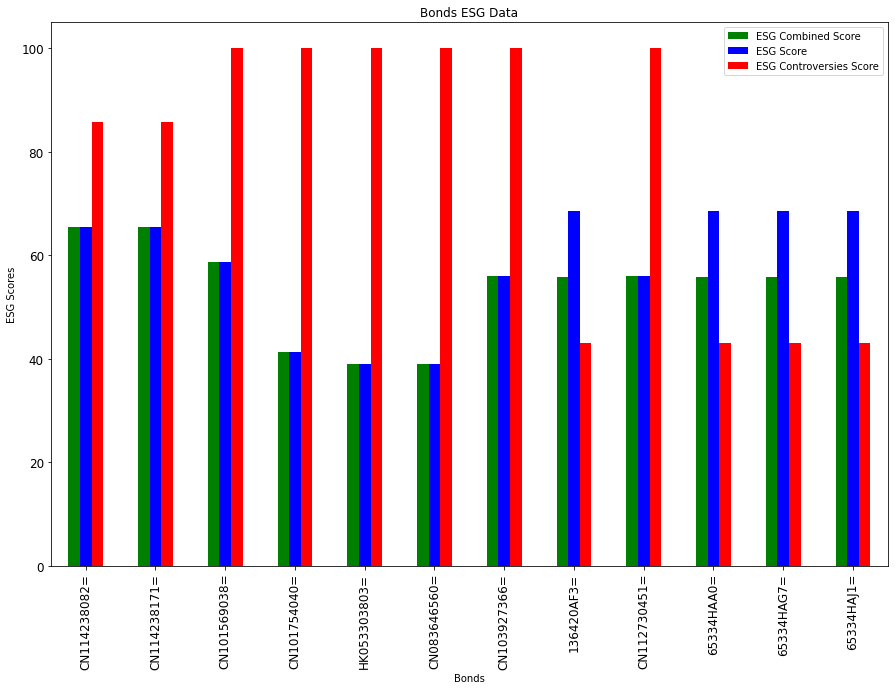

In [19]:
df_bonds_esg.plot(kind="bar", x = 'Instrument',figsize=(15,10), fontsize=12, color=['g', 'b', 'r'])
plt.title("Bonds ESG Data")
plt.xlabel("Bonds")
plt.ylabel("ESG Scores")
plt.show()

## <a id="references"></a>References

You can find more detail regarding the Eikon Data APIs, RDP Library for Python and related technologies from the following resources:
* [Refinitiv Eikon Data API page](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api) on the [Refinitiv Developer Community](https://developers.refinitiv.com/) web site.
* [Eikon Data API Quick Start Guide page](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api/quick-start).
* [Eikon Data API Tutorial page](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api/tutorials).
* [Python Quants Video Tutorial Series for Eikon API](https://community.developers.refinitiv.com/questions/37865/announcement-new-python-quants-video-tutorial-seri.html).
* [Eikon Data APY Python Reference Guide](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api/documentation#eikon-data-ap-is-for-python-reference-guide).
* [Eikon Data API Troubleshooting article](https://developers.refinitiv.com/en/article-catalog/article/eikon-data-api-python-troubleshooting-refinitiv).
* [Refinitiv Data Platform (RDP) Libraries](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries) on the [Refinitiv Developer Community](https://developers.refinitiv.com/) web site.
* [RDP Libraries Quick Start Guide page](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries/quick-start).
* [RDP Libraries Tutorial page](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries/tutorials).
* [Discover our Refinitiv Data Platform Library (part 1)](https://developers.refinitiv.com/en/article-catalog/article/discover-our-refinitiv-data-platform-library-part-1).
* [Discover our Refinitiv Data Platform Library (part 2)](https://developers.refinitiv.com/en/article-catalog/article/discover-our-refinitiv-data-platform-library-part-2).
* [Find Your Right Companies with SCREENER](https://developers.refinitiv.com/en/article-catalog/article/find-your-right-companies-with-screener-eikon-data-apis-python).
* [Building Search into your Application Workflow](https://developers.refinitiv.com/en/article-catalog/article/building-search-into-your-application-workflow).
* [Debt Structure Analysis on an Organizational Level](https://developers.refinitiv.com/en/article-catalog/article/debt-structure-analysis-on-an-organizational-level).

For any question related to this example or Eikon Data API, please use the Developers Community [Q&A Forum - Eikon Data API](https://community.developers.refinitiv.com/spaces/92/eikon-scripting-apis.html).

For any question related to this example or Eikon Data API, please use the Developers Community [Q&A Forum - Refinitiv Data Platform](https://community.developers.refinitiv.com/spaces/231/index.html).


## <a id="github"><a>GitHub
    
- [Building Search into your Application Workflow](https://github.com/Refinitiv-API-Samples/Article.RDPLibrary.Python.Search)
- [Debt Structure Analysis on an Organizational Level](https://github.com/Refinitiv-API-Samples/Article.RDPLibrary.Python.DebtStructure) 